<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/k_m_n190.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyotp --q
!pip install smartapi-python==1.4.1 --q
!pip install logzero --q
!pip install pykalman --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 11.4 MB/s eta 0:00:00


In [2]:
from SmartApi import SmartConnect #or from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger
import time
import os
import urllib
import json
import pandas as pd
import datetime as dt

In [3]:
api_key = 'xOHnB7MG'
username = 'M55123447'
pwd = '1471'
smartApi = SmartConnect(api_key)
try:
    token = "GJZACUQI2TTAIBHBA34XNFJURQ"
    totp = pyotp.TOTP(token).now()
except Exception as e:
    logger.error("Invalid Token: The provided token is not valid.")
    raise e

correlation_id = "abcde"
data = smartApi.generateSession(username, pwd, totp)

if data['status'] == False:
    logger.error(data)

else:
    # login api call
    # logger.info(f"You Credentials: {data}")
    authToken = data['data']['jwtToken']
    refreshToken = data['data']['refreshToken']
    # fetch the feedtoken
    feedToken = smartApi.getfeedToken()
    # fetch User Profile
    res = smartApi.getProfile(refreshToken)
    smartApi.generateToken(refreshToken)
    res=res['data']['exchanges']
#Download Nifty50 Index Data
params = {
           "exchange": "NSE",
           "symboltoken": '99926000',
           "interval": "ONE_DAY",
           "fromdate": (dt.datetime(2021, 3, 7).strftime('%Y-%m-%d %H:%M')),
           "todate": (dt.datetime.today().strftime('%Y-%m-%d %H:%M'))
         }
nifty_data = smartApi.getCandleData(params)
nifty_data_format= pd.DataFrame(nifty_data["data"],
                               columns = ["Date","Open","High","Low","Close","Volume"])
nifty_data_format.set_index("Date",inplace=True)
nifty_data_format.index = pd.to_datetime(nifty_data_format.index)
nifty_data_format.index = nifty_data_format.index.tz_localize(None)

In [4]:
nifty_data_format.head(2)

,Open,High,Low,Close,Volume
Date,,,,,
2021-03-08,15002.45,15111.15,14919.90,14956.2,0
2021-03-09,15049.90,15126.85,14925.45,15098.4,0


In [5]:
# ---------------------------------------------------------------------------
# 1.  Prep: pick the price series you want to filter
# ---------------------------------------------------------------------------
close = nifty_data_format['Close'].copy()

# ---------------------------------------------------------------------------
# 2.  Helper: simple 1-D Kalman filter wrapper
#     delta   → process noise; bigger  = faster response
#     obs_var → observation noise (how noisy you think the price is)
# ---------------------------------------------------------------------------
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def kalman_1d(series: pd.Series, delta: float, obs_var: float = 1e-3) -> pd.Series:
    """
    Returns the filtered series using a basic local-level Kalman filter
    (state: price level; transition matrix = 1).
    """
    kf = KalmanFilter(
        transition_matrices        = [1],
        observation_matrices       = [1],
        initial_state_mean         = series.iloc[0],
        initial_state_covariance   = 1.0,
        transition_covariance      = delta,      # process noise Q
        observation_covariance     = obs_var,    # observation noise R
    )
    state_means, _ = kf.filter(series.values)
    return pd.Series(state_means.flatten(), index=series.index)

# ---------------------------------------------------------------------------
# 3.  Compute fast & slow Kalman filters
#     Tune `delta_fast` and `delta_slow` until the speed feels right.
# ---------------------------------------------------------------------------
delta_fast = 1e-4   # higher  →  hugs price more closely
delta_slow = 5e-6
kf_fast = kalman_1d(close, delta_fast, obs_var=1e-3)
kf_slow = kalman_1d(close, delta_slow, obs_var=1e-3)

# ---------------------------------------------------------------------------
# 4.  Spread and percentile rank
# ---------------------------------------------------------------------------
spread = kf_fast - kf_slow

# Percentile rank of each day’s spread vs. *entire* history
spread_pct = spread.rank(pct=True) * 100      # 0–100 scale


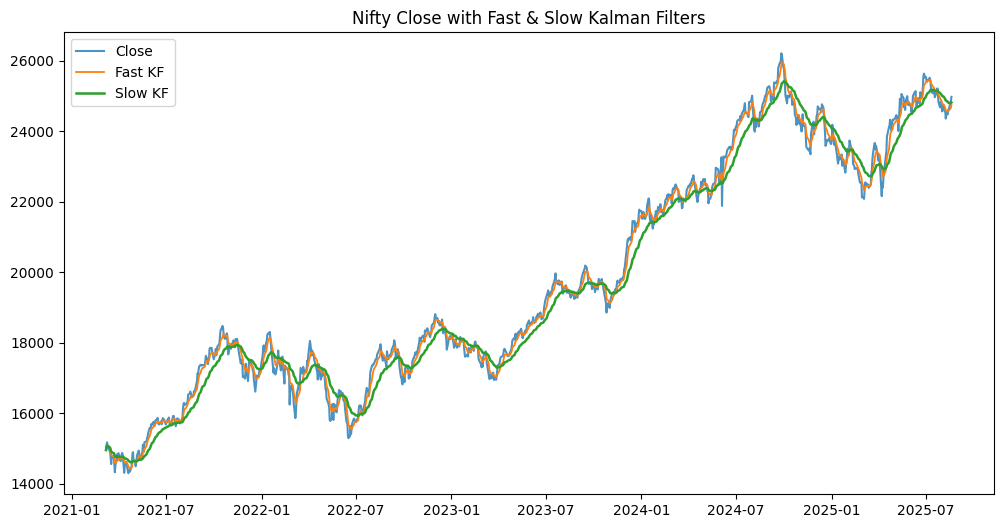

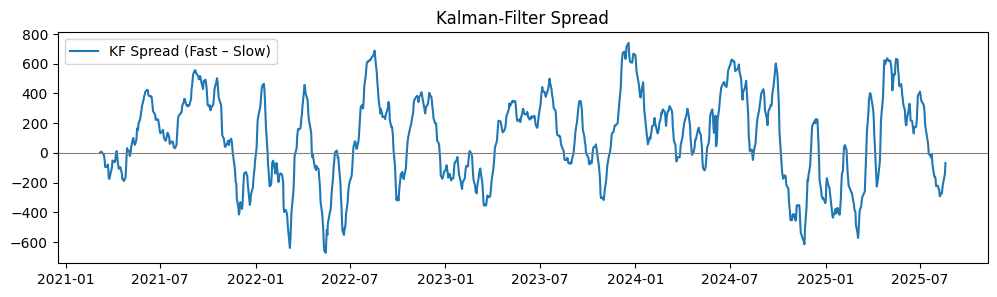

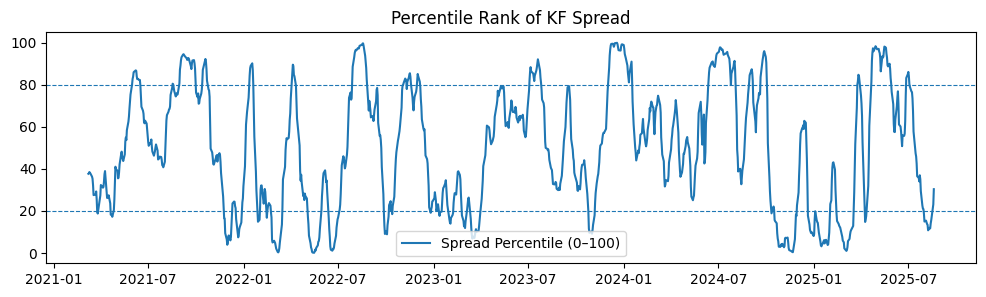

In [6]:

# ---------------------------------------------------------------------------
# 5.  Plot
# ---------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(close,    label='Close',        alpha=0.8)
plt.plot(kf_fast,  label='Fast KF',      lw=1.3)
plt.plot(kf_slow,  label='Slow KF',      lw=1.8)
plt.title('Nifty Close with Fast & Slow Kalman Filters')
plt.legend()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(spread, label='KF Spread (Fast – Slow)')
plt.title('Kalman-Filter Spread')
plt.axhline(0, color='grey', lw=0.8)
plt.legend()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(spread_pct, label='Spread Percentile (0–100)')
plt.title('Percentile Rank of KF Spread')
plt.axhline(80, ls='--', lw=0.8)   # example upper threshold
plt.axhline(20, ls='--', lw=0.8)   # example lower threshold
plt.legend()
plt.show()


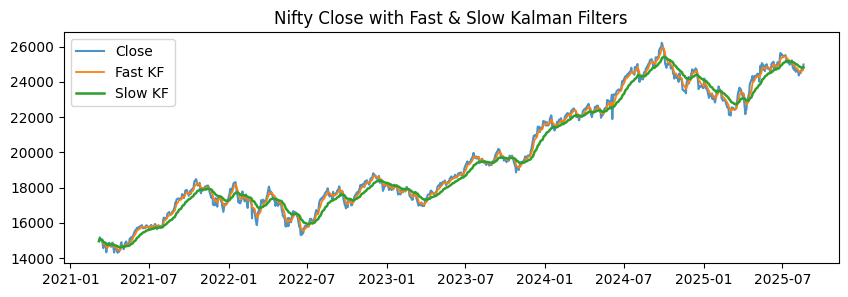

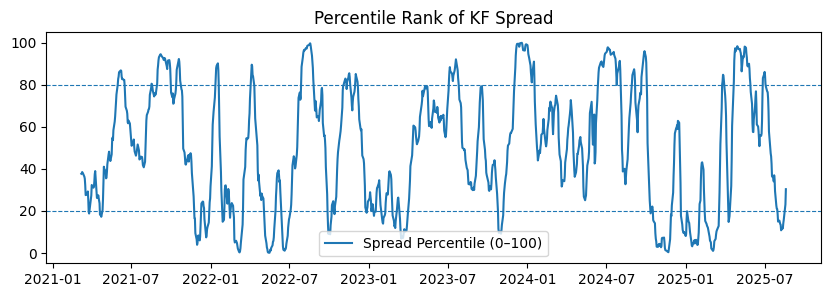

In [7]:
plt.figure(figsize=(10, 3))
plt.plot(close,    label='Close',        alpha=0.8)
plt.plot(kf_fast,  label='Fast KF',      lw=1.3)
plt.plot(kf_slow,  label='Slow KF',      lw=1.8)
plt.title('Nifty Close with Fast & Slow Kalman Filters')
plt.legend()
plt.show()
plt.figure(figsize=(10, 3))
plt.plot(spread_pct, label='Spread Percentile (0–100)')
plt.title('Percentile Rank of KF Spread')
plt.axhline(80, ls='--', lw=0.8)   # example upper threshold
plt.axhline(20, ls='--', lw=0.8)   # example lower threshold
plt.legend()
plt.show()

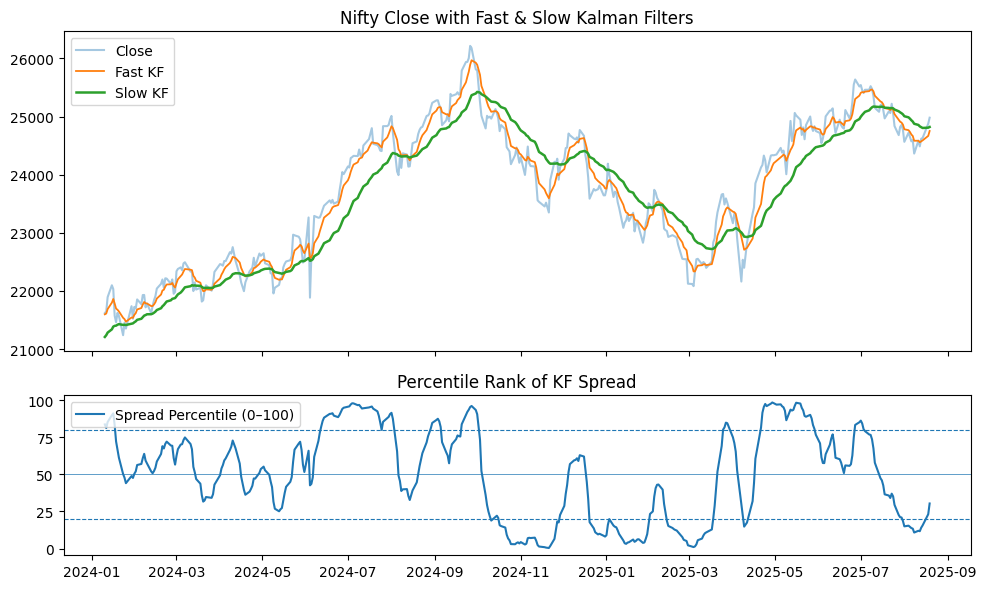

In [8]:
import matplotlib.pyplot as plt

# --- one figure, two stacked axes sharing the x-axis -------------------------
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,          # <-- key line: share the datetime x-axis
    figsize=(10, 6),
    gridspec_kw={"height_ratios": [2, 1]},  # taller price pane, thinner spread pane
)

# Top pane: price + Kalman filters
ax1.plot(close[-400:],   label='Close',   alpha=0.4)
ax1.plot(kf_fast[-400:], label='Fast KF', lw=1.3)
ax1.plot(kf_slow[-400:], label='Slow KF', lw=1.8)
ax1.set_title('Nifty Close with Fast & Slow Kalman Filters')
ax1.legend(loc='upper left')

# Bottom pane: percentile-ranked spread
ax2.plot(spread_pct[-400:], label='Spread Percentile (0–100)')
ax2.axhline(80, ls='--', lw=0.8)
ax2.axhline(20, ls='--', lw=0.8)
ax2.axhline(50, ls='-', lw=0.5)
ax2.set_title('Percentile Rank of KF Spread')
ax2.legend(loc='upper left')

plt.tight_layout()       # prevent label overlap
plt.show()


In [9]:
float(round(spread_pct.iloc[-1],2))

30.34

In [10]:
srd_pct=np.where((close[-400:]-kf_fast[-400:])>0,1,-1)

In [11]:
srd_pct[-10:]

array([-1, -1, -1, -1,  1, -1,  1,  1,  1,  1])

In [12]:
def impulse(close: pd.Series,
            ema_span: int = 13,
            macd_fast: int = 12,
            macd_slow: int = 26,
            macd_signal: int = 9) -> int:
            """
            Return the *last* Elder Impulse color as:
            1 = green, 0 = blue, -1 = red

            Parameters
             ----------
            close : pd.Series of prices (index = time)
            ema_span, macd_fast, macd_slow, macd_signal : standard Elder defaults

            Notes
            ----
            Uses slope(EMA13) and slope(MACD histogram).
            """
            close = pd.Series(close).astype(float)

            # Trend: EMA(13) slope
            ema = close.ewm(span=ema_span, adjust=False).mean()
            trend_up = ema.diff() > 0   # True if rising, False if falling

            # Momentum: MACD histogram slope
            ema_fast = close.ewm(span=macd_fast, adjust=False).mean()
            ema_slow = close.ewm(span=macd_slow, adjust=False).mean()
            macd = ema_fast - ema_slow
            macd_sig = macd.ewm(span=macd_signal, adjust=False).mean()
            hist = macd - macd_sig
            mom_up = hist.diff() > 0    # True if rising, False if falling

            # Color compression
            imp_series = pd.Series(np.where(trend_up & mom_up,1,np.where((~trend_up) & (~mom_up), -1, 0)),index=close.index)

            # Drop early NaNs (insufficient lookback) and return last valid
            imp_series = imp_series.where(trend_up.notna() & mom_up.notna())
            if imp_series.notna().any():
               return int(imp_series.dropna().iloc[-1])
            else:

               return None   # fallback if not enough data

In [13]:
last_color= impulse(close)

In [14]:
last_color

1

In [16]:
if 20<spread_pct.iloc[-1]<90 and last_color!=-1 and srd_pct[-1]==1:
  print("BUY")
elif 10<spread_pct.iloc[-1]<45 and last_color!=1 and srd_pct[-1]==-1:
  print("SELL")
else:
  print("Wait for Signal")

BUY
